In [2]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2024-03-06 14:33:04.874808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 14:33:04.947440: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 14:33:04.964641: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 14:33:05.259696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

2.10.0


In [3]:
GRAIN_TYPE = 'Wheat'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
             #       'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Variety']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [4]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Variety'].nunique()
varieties = df_targets['Variety'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Variety'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


2024-03-06 14:33:06.438938: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-03-06 14:33:06.438960: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: usda-ars
2024-03-06 14:33:06.438965: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: usda-ars
2024-03-06 14:33:06.439048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.161.7
2024-03-06 14:33:06.439065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.154.5
2024-03-06 14:33:06.439069: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration
2024-03-06 14:33:06.439437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

In [5]:
from sklearn.model_selection import train_test_split

# Convert the one-hot encoded labels back to integer encoded labels for stratification
y_integers = np.argmax(y_one_hot, axis=1)

# Perform stratified train-test split on the data
X_trainVal, X_test, y_trainVal_integer, y_test_integer = train_test_split(
    dataset_x, y_integers, test_size=0.20, stratify=y_integers, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_trainVal = tf.one_hot(y_trainVal_integer, depth).numpy()
y_test = tf.one_hot(y_test_integer, depth).numpy()

# Stratified split for the validation set
X_train, X_val, y_train_integer, y_val_integer = train_test_split(
    X_trainVal, y_trainVal_integer, test_size=0.15, stratify=y_trainVal_integer, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_train = tf.one_hot(y_train_integer, depth).numpy()
y_val = tf.one_hot(y_val_integer, depth).numpy()


In [6]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define model
model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(5, activation='softmax')  # Changed to softmax for multi-class
])

# Compile model with per-class precision and recall
metrics = ['accuracy']  # General accuracy for all classes

# Add precision and recall for each class
for i in range(depth):
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=f'precision_class_{i}'))
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=f'recall_class_{i}'))

model.compile(
    loss='categorical_crossentropy',  # Correct loss for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00033),  
    metrics=metrics
)
history = model.fit(X_train, y_train, epochs=1100, batch_size=8)
model.save(FILENAME_BEST_MODEL)

Epoch 1/1100
51/51 [==============================] - 1s 724us/step - loss: 1.4841 - accuracy: 0.3407 - precision_class_0: 0.0000e+00 - recall_class_0: 0.0000e+00 - precision_class_1: 0.0000e+00 - recall_class_1: 0.0000e+00 - precision_class_2: 0.0000e+00 - recall_class_2: 0.0000e+00 - precision_class_3: 0.0000e+00 - recall_class_3: 0.0000e+00 - precision_class_4: 0.8824 - recall_class_4: 0.1829   
Epoch 2/1100
51/51 [==============================] - 0s 635us/step - loss: 1.2547 - accuracy: 0.4657 - precision_class_0: 0.5714 - recall_class_0: 0.0494 - precision_class_1: 0.0000e+00 - recall_class_1: 0.0000e+00 - precision_class_2: 0.0000e+00 - recall_class_2: 0.0000e+00 - precision_class_3: 0.8333 - recall_class_3: 0.0617 - precision_class_4: 0.7000 - recall_class_4: 0.4268                  
Epoch 3/1100
51/51 [==============================] - 0s 581us/step - loss: 1.1124 - accuracy: 0.5466 - precision_class_0: 0.7778 - recall_class_0: 0.1728 - precision_class_1: 0.0000e+00 - recall_c

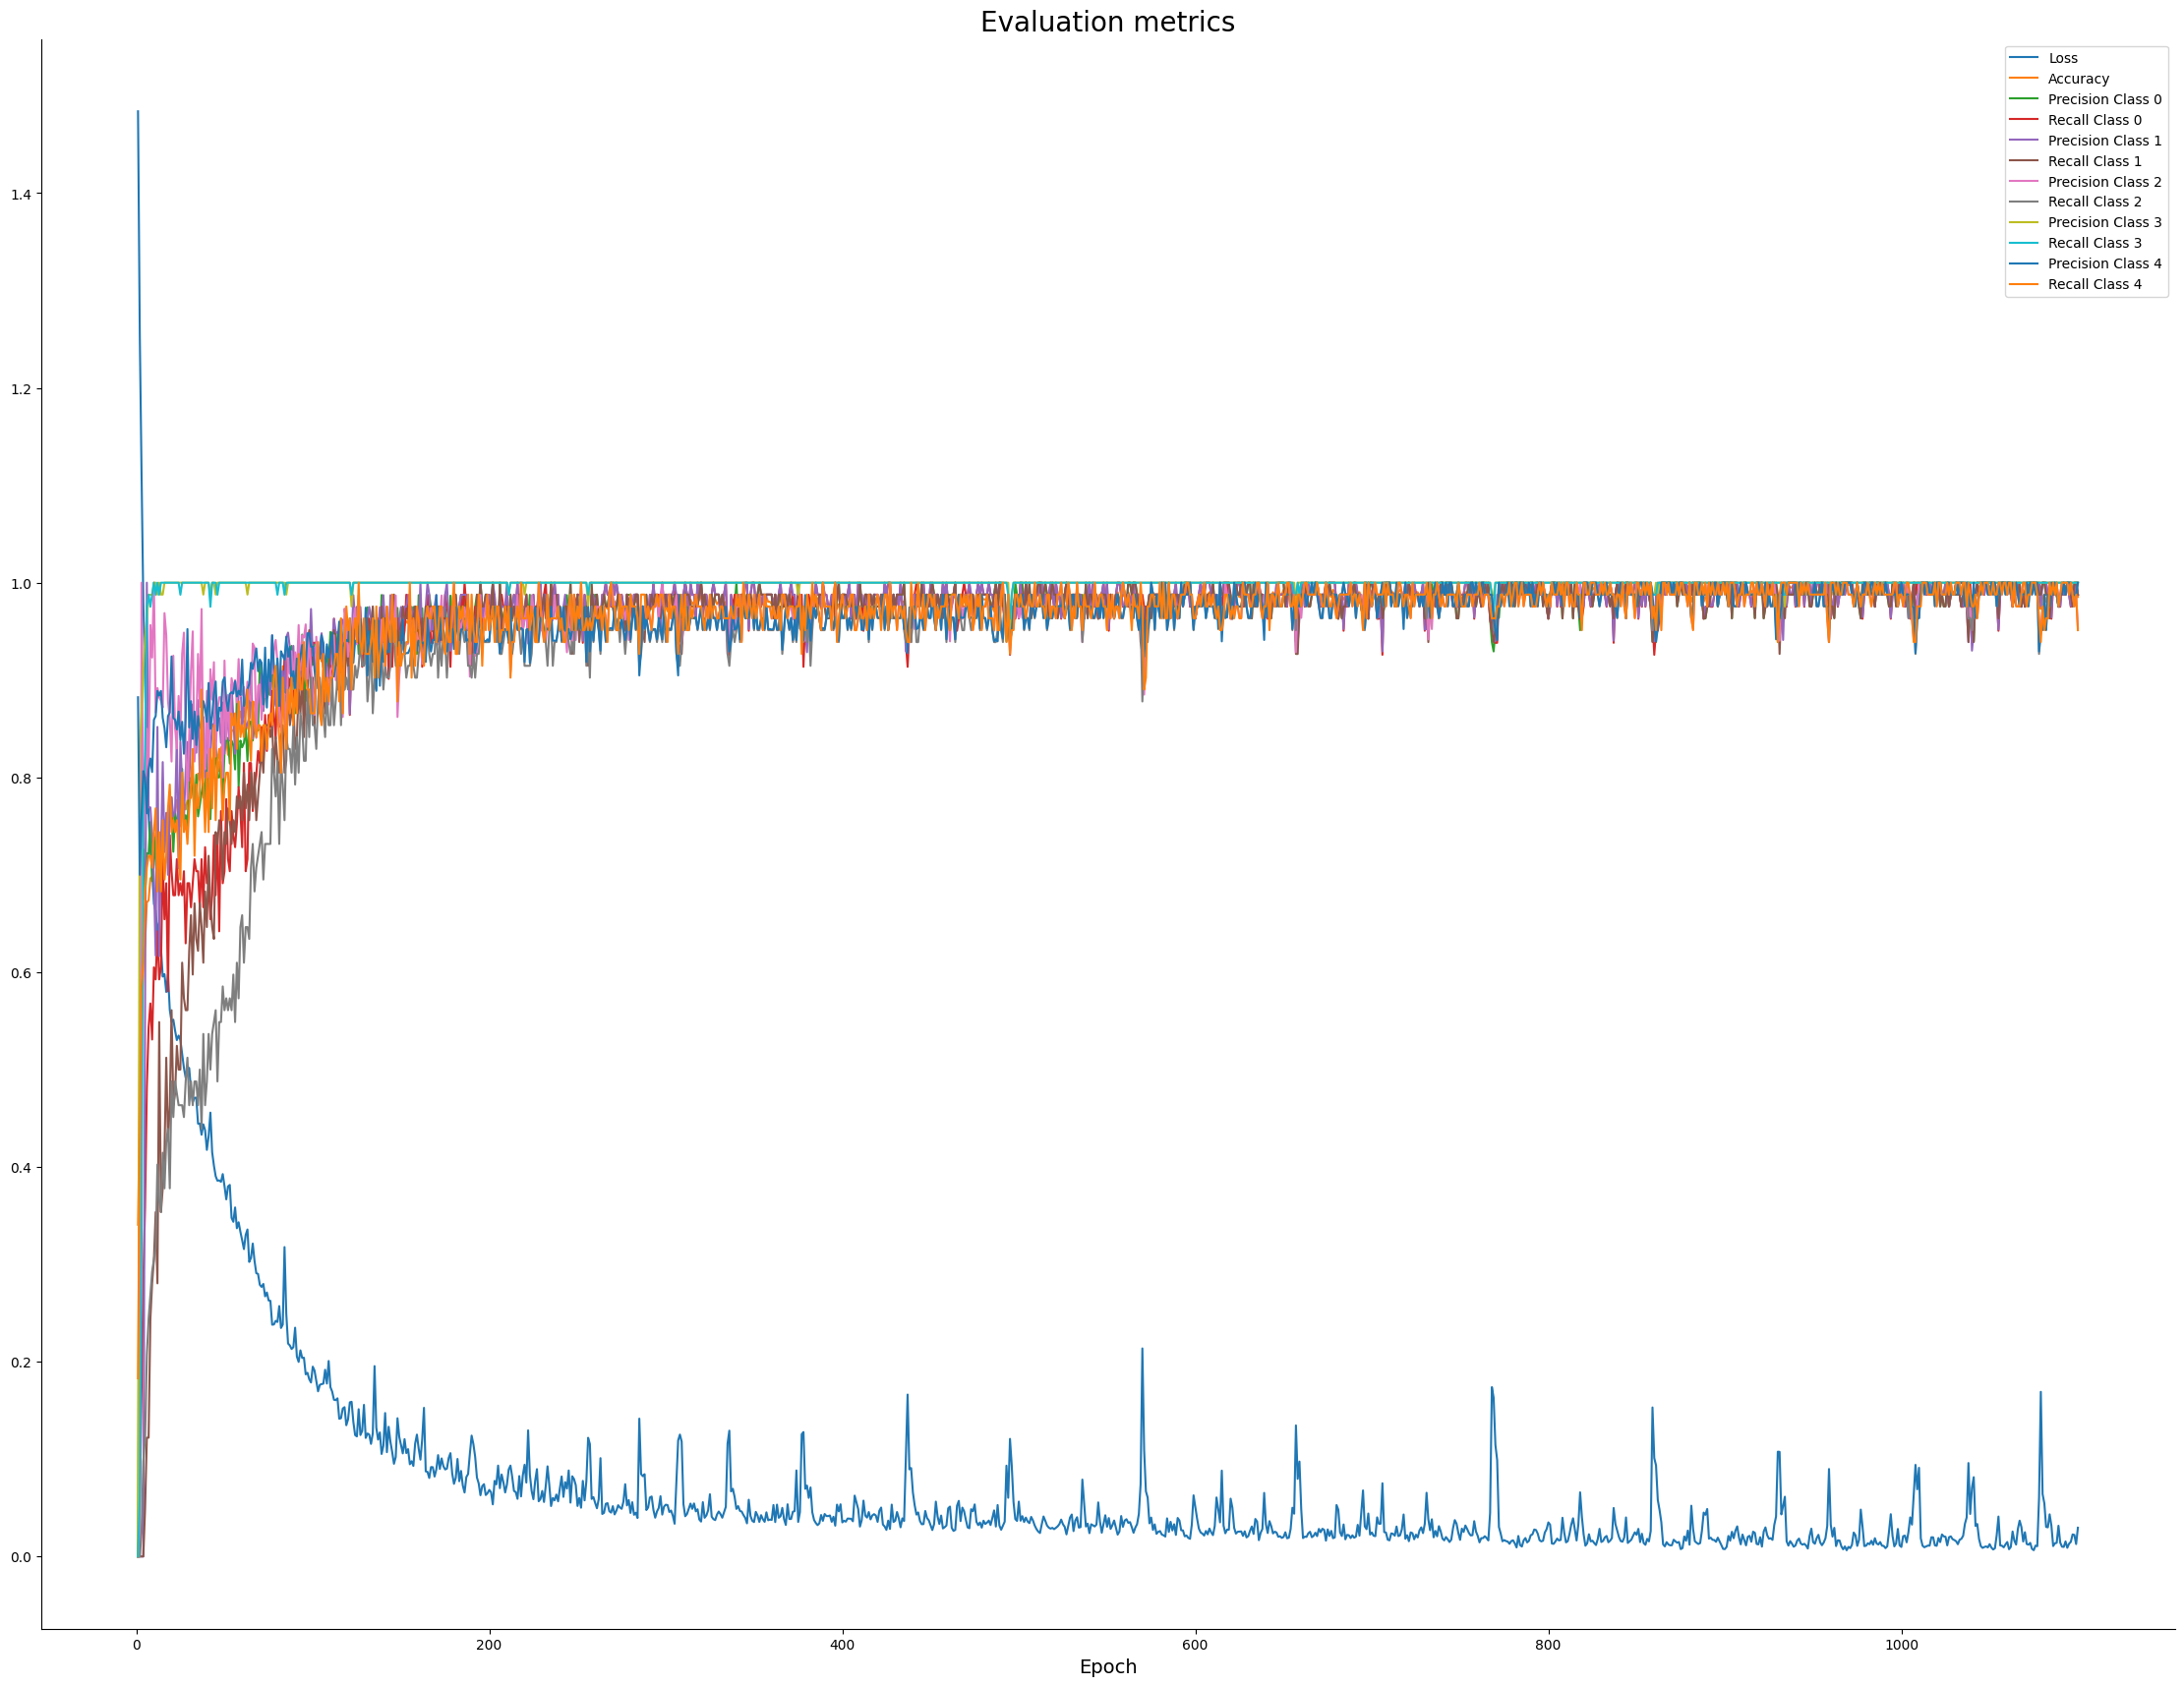

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [11]:
# Evaluate the model on the test data
test_loss, test_accuracy, *test_metrics = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Assuming the order of metrics is consistent with how we added them:
# test_metrics[0] -> precision_class_0, test_metrics[1] -> recall_class_0, etc.
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

num_classes = 5  # Update this with the actual number of classes you have


def compute_confusion_matrix(true, pred):
    classes = np.unique(true)
    conf_mat = [[0] * len(classes) for i in range(len(classes))]
    for i in range(len(true)):
        conf_mat[pred[i]][true[i]]+=1
    print("       Actual")
    print("      _",end="")
    for item in classes:
        print("____",end="")
    print()
    print("pred  |", end=" "),
    for item in classes:
        print("{:^3}".format(item), end=" ")
    print()
    for item in classes:
        print("{:^6}|".format(item), end=" ")
        for item2 in classes:
            print("{:^3}".format(conf_mat[item][item2]), end="|")
        print()
def compute_metrics_per_class(true, pred, test_metrics):
    classes = np.unique(true)
    conf_mat = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(true)):
        conf_mat[pred[i], true[i]] += 1

    num_classes = len(classes)

    total_precision = 0
    total_recall = 0
    total_accuracy = 0

    for i in range(num_classes):
        precision = float(test_metrics[2 * i])  # Even indices for precision
        recall = float(test_metrics[2 * i + 1])  # Odd indices for recall
        accuracy = float(conf_mat[i, i]) / np.sum(conf_mat[:, i])  # Calculate accuracy for class i
        
        total_precision += precision
        total_recall += recall
        total_accuracy += accuracy

        print(f"Class {i:2} | Precision: {precision:.3f} | Recall: {recall:.3f} | Accuracy: {accuracy:.3f}")

    # Calculate and print the averages
    avg_precision = total_precision / num_classes
    avg_recall = total_recall / num_classes
    avg_accuracy = total_accuracy / num_classes
    print(f"\nAverage Precision: {avg_precision:.3f} | Average Recall: {avg_recall:.3f} | Average Accuracy: {avg_accuracy:.3f}")

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_nums = np.argmax(y_test, axis=1)
compute_confusion_matrix(y_test_nums.tolist(),y_pred_labels.tolist())
print()
compute_metrics_per_class(y_test_nums.tolist(),y_pred_labels.tolist(),test_metrics)

1/4 [======>.......................] - ETA: 0s - loss: 0.0241 - accuracy: 1.0000 - precision_class_0: 1.0000 - recall_class_0: 1.0000 - precision_class_1: 1.0000 - recall_class_1: 1.0000 - precision_class_2: 1.0000 - recall_class_2: 1.0000 - precision_class_3: 1.0000 - recall_class_3: 1.0000 - precision_class_4: 1.0000 - recall_class_4: 1.0000

4/4 [==============================] - 0s 735us/step
       Actual
      _____________________
pred  |  0   1   2   3   4  
  0   | 21 | 0 | 1 | 0 | 0 |
  1   |  0 |24 | 0 | 0 | 0 |
  2   |  1 | 0 |23 | 0 | 1 |
  3   |  0 | 0 | 0 |24 | 0 |
  4   |  2 | 0 | 0 | 0 |23 |

Class  0 | Precision: 0.955 | Recall: 0.875 | Accuracy: 0.875
Class  1 | Precision: 1.000 | Recall: 1.000 | Accuracy: 1.000
Class  2 | Precision: 0.920 | Recall: 0.958 | Accuracy: 0.958
Class  3 | Precision: 1.000 | Recall: 1.000 | Accuracy: 1.000
Class  4 | Precision: 0.920 | Recall: 0.958 | Accuracy: 0.958
